In [27]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [5]:
df = pd.read_csv('../data/zillow_data.csv')
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [6]:
df.groupby('RegionID')['State'].count()

RegionID
58196     1
58197     1
58200     1
58201     1
58202     1
         ..
677175    1
698721    1
738092    1
753843    1
753844    1
Name: State, Length: 14723, dtype: int64

In [7]:
df_nv = df[df['State'] == 'NV']
nv_zipcodes = list(df_nv.RegionID)
nv_zipcodes[0]

95804

In [8]:
df_time_series = pd.DataFrame(index=pd.to_datetime(df.columns[7:]), data=np.ones(len(df.columns)-7))
for i in range(df.shape[0]):
    df_time_series[df['RegionID'][i]] = df.iloc[i,7:]
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)
df_time_series

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,1024400,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,1030700,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,1033800,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [9]:
df_time_series.fillna(method='bfill', inplace=True)

In [10]:
df_time_series.isna().sum().sum()

0

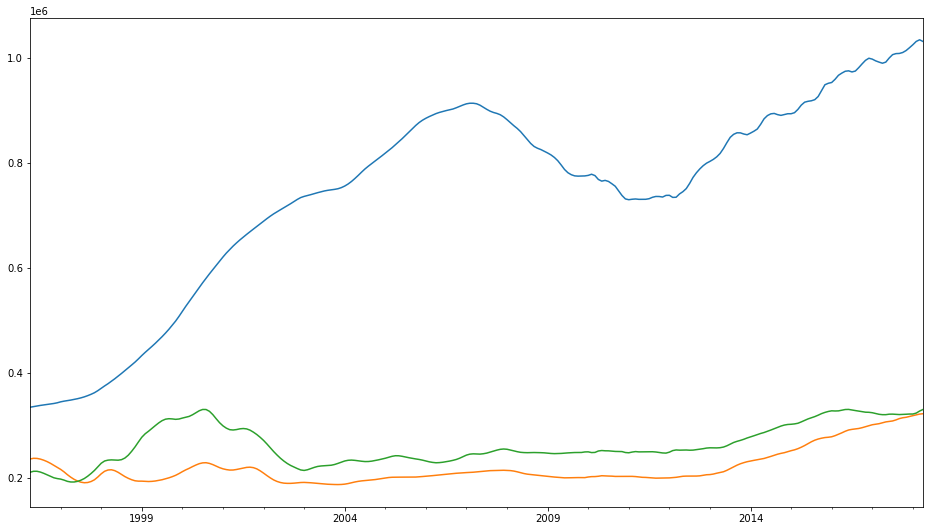

In [11]:
df_time_series.iloc[:,0].plot(figsize=(16,9))
df_time_series.iloc[:,1].plot()
df_time_series.iloc[:,2].plot();

use p value from df test on skylar chart

In [12]:
df['CountyName'].value_counts().head(20)

Los Angeles    264
Jefferson      175
Orange         166
Washington     164
Montgomery     159
Cook           140
Harris         127
Jackson        118
Middlesex      117
Maricopa       111
Franklin       110
Suffolk        110
Clark           94
Marion          92
Monroe          90
San Diego       87
Madison         85
Douglas         83
Lake            79
Dallas          77
Name: CountyName, dtype: int64

# RNN Model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler


In [14]:
df = pd.read_csv('../data/zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [15]:
df_time_series = pd.DataFrame(index=pd.to_datetime(df.columns[7:]), data=np.ones(len(df.columns)-7))
for i in range(df.shape[0]):
    df_time_series[df['RegionID'][i]] = df.iloc[i,7:]
df_time_series.drop(df_time_series.columns[0],axis=1, inplace=True)
df_time_series

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200,235700,210400,498100,77300,95000,152900,216500,95400,766000,...,80800,135900,78300,136200,62500,94600,92700,57100,191100,176400
1996-05-01,335400,236900,212200,500900,77300,95200,152700,216700,95600,771100,...,80100,136300,78300,136600,62600,94300,92500,57300,192400,176300
1996-06-01,336500,236700,212200,503100,77300,95400,152600,216900,95800,776500,...,79400,136600,78200,136800,62700,94000,92400,57500,193700,176100
1996-07-01,337600,235400,210700,504600,77300,95700,152400,217000,96100,781900,...,78600,136900,78200,136800,62700,93700,92200,57700,195000,176000
1996-08-01,338500,233300,208300,505500,77400,95900,152300,217100,96400,787300,...,77900,137100,78100,136700,62700,93400,92100,58000,196300,175900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700,316600,321200,1299000,120300,162800,414300,777900,172300,3778700,...,123400,257600,171300,341000,122800,216400,213100,130600,694700,348900
2018-01-01,1024400,318100,321200,1302700,120300,162800,413900,778500,173300,3770800,...,124400,258000,172400,342300,123200,213100,213700,131700,706400,350400
2018-02-01,1030700,319600,323000,1306400,120500,162900,411400,780500,174200,3763100,...,125500,260600,173600,345000,123200,209800,218300,132500,705300,353000
2018-03-01,1033800,321100,326900,1308500,121000,163500,413200,782800,175400,3779800,...,126600,264700,175800,348000,120700,209200,222700,133000,681500,356000


In [16]:
df_time_series.fillna(method='bfill')

,84654,90668,91982,84616,93144,91733,61807,84640,91940,97564,...,59187,94711,62556,99032,62697,58333,59107,75672,93733,95851
1996-04-01,334200.0,235700.0,210400.0,498100.0,77300.0,95000.0,152900.0,216500.0,95400.0,766000.0,...,80800.0,135900.0,78300.0,136200.0,62500.0,94600.0,92700.0,57100.0,191100.0,176400.0
1996-05-01,335400.0,236900.0,212200.0,500900.0,77300.0,95200.0,152700.0,216700.0,95600.0,771100.0,...,80100.0,136300.0,78300.0,136600.0,62600.0,94300.0,92500.0,57300.0,192400.0,176300.0
1996-06-01,336500.0,236700.0,212200.0,503100.0,77300.0,95400.0,152600.0,216900.0,95800.0,776500.0,...,79400.0,136600.0,78200.0,136800.0,62700.0,94000.0,92400.0,57500.0,193700.0,176100.0
1996-07-01,337600.0,235400.0,210700.0,504600.0,77300.0,95700.0,152400.0,217000.0,96100.0,781900.0,...,78600.0,136900.0,78200.0,136800.0,62700.0,93700.0,92200.0,57700.0,195000.0,176000.0
1996-08-01,338500.0,233300.0,208300.0,505500.0,77400.0,95900.0,152300.0,217100.0,96400.0,787300.0,...,77900.0,137100.0,78100.0,136700.0,62700.0,93400.0,92100.0,58000.0,196300.0,175900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,1018700.0,316600.0,321200.0,1299000.0,120300.0,162800.0,414300.0,777900.0,172300.0,3778700.0,...,123400.0,257600.0,171300.0,341000.0,122800.0,216400.0,213100.0,130600.0,694700.0,348900.0
2018-01-01,1024400.0,318100.0,321200.0,1302700.0,120300.0,162800.0,413900.0,778500.0,173300.0,3770800.0,...,124400.0,258000.0,172400.0,342300.0,123200.0,213100.0,213700.0,131700.0,706400.0,350400.0
2018-02-01,1030700.0,319600.0,323000.0,1306400.0,120500.0,162900.0,411400.0,780500.0,174200.0,3763100.0,...,125500.0,260600.0,173600.0,345000.0,123200.0,209800.0,218300.0,132500.0,705300.0,353000.0
2018-03-01,1033800.0,321100.0,326900.0,1308500.0,121000.0,163500.0,413200.0,782800.0,175400.0,3779800.0,...,126600.0,264700.0,175800.0,348000.0,120700.0,209200.0,222700.0,133000.0,681500.0,356000.0


In [17]:
df_time_series[95768]

1996-04-01    131200
1996-05-01    131000
1996-06-01    130800
1996-07-01    130600
1996-08-01    130400
               ...  
2017-12-01    178400
2018-01-01    179400
2018-02-01    179800
2018-03-01    180500
2018-04-01    181200
Name: 95768, Length: 265, dtype: object

In [18]:
size = int(len(df_time_series)*.8)
train = df_time_series.iloc[:size]
test = df_time_series.iloc[size:]

In [19]:
len(train)-60

152

In [20]:
train = train[nv_zipcodes]
test = test[nv_zipcodes]

In [21]:
x = 0
train_data = train.iloc[:,x:x+1].values.astype(int)
test_data = test.iloc[:,x:x+1].values.astype(int)

In [22]:
scaler = MinMaxScaler(feature_range=(0,1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.fit_transform(test_data)

Creating a dataset with 60 timesteps (5 years)

In [23]:
X_train = []
y_train = []
for i in range(60,len(train_data_scaled)):
    X_train.append(train_data_scaled[i-60:i])
    y_train.append(train_data_scaled[i])

data_total = pd.concat((train.iloc[:,x:x+1], test.iloc[:,x:x+1]),axis=0)
inputs = data_total[len(train)-60:].values
inputs = scaler.transform(inputs)

X_test = []
y_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i])
X_test = np.array(X_test)
y_test = np.array(test_data)

Turn data into arrays for RNN

In [24]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

Initialize RNN Model

In [25]:
rnn_model = Sequential()

Building the first layer

In [26]:
rnn_model.add(LSTM(units= 50, return_sequences = True, input_shape=(X_train.shape[1:])))
rnn_model.add(Dropout(.2))

NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [28]:
rnn_model.add(LSTM(units= 50, return_sequences = True))
rnn_model.add(Dropout(.2))

In [29]:
rnn_model.add(LSTM(units= 50, return_sequences = True))
rnn_model.add(Dropout(.2))

In [30]:
rnn_model.add(LSTM(units= 50, return_sequences = False))
rnn_model.add(Dropout(.2))

In [31]:
rnn_model.add(Dense(units=1))


In [32]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [34]:
rnn_model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
5/5 [==============================] - 0s 49ms/step - loss: 0.4187
Epoch 2/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0823
Epoch 3/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0310
Epoch 4/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0397
Epoch 5/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0179
Epoch 6/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0214
Epoch 7/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0149
Epoch 8/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0170
Epoch 9/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0144
Epoch 10/100
5/5 [==============================] - 0s 43ms/step - loss: 0.0129
Epoch 11/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0136
Epoch 12/100
5/5 [==============================] - 0s 44ms/step - loss: 0.0150
Epoch 13/100
5/5 [==============================]

Test the 20% test Data

In [35]:
y_hat_raw = rnn_model.predict(X_test)
y_hat = scaler.inverse_transform(y_hat_raw)

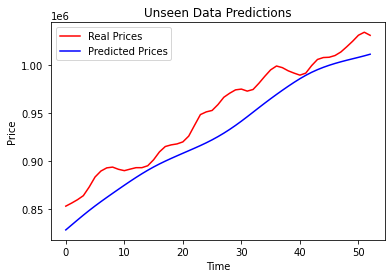

In [36]:
plt.plot(y_test, color='red', label='Real Prices')
plt.plot(y_hat, color='blue', label='Predicted Prices')
plt.title('Unseen Data Predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show;

In [37]:
zipcodes = df_time_series.columns

In [38]:
df_time_series.isna().sum().sum()

156891

In [39]:
df_time_series.fillna(method='bfill',inplace=True)

In [2]:
zipcodes = nv_zipcodes
dict_mape = {}
dict_next_5_years = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 30, return_sequences = True, input_shape=((60,1))))
    rnn_model.add(Dropout(.2))

    # 3 other layers
    rnn_model.add(LSTM(units= 30, return_sequences = True))
    rnn_model.add(Dropout(.2))

    rnn_model.add(LSTM(units= 30, return_sequences = True))
    rnn_model.add(Dropout(.2))

    # return_sequence is False because we want only 1 output after this layer
    rnn_model.add(LSTM(units= 30, return_sequences = False))
    rnn_model.add(Dropout(.2))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_squared_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.fit_transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test,y_test))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    

    predictions = []
    # We will make next 60 predictions
    for i in range(24):
        # Our input should be in (x,60,1) format
        x_new_pred = last_60[-60:].reshape(1,60,1)

        # make a prediction, add to the last_60 for the next prediction and 
        y_pred = rnn_model.predict(x_new_pred)

        # We add our predition to our list of predictions for zipcode specific predictions list
        predictions.append(scaler.inverse_transform(y_pred))

        last_60 = np.append(last_60,y_pred)
        

    dict_next_5_years[zipcodes[zipcode]] = predictions
    print(f'Iteration number {zipcode} finished')
    

NameError: name 'nv_zipcodes' is not defined

In [99]:
dict_mape

{95804: 0.05467682170463134,
 95817: 0.056657457760375556,
 95813: 0.10627834888752286,
 95785: 0.08986851430738302,
 95819: 0.08810381854497155,
 95770: 0.057699379562738316,
 95806: 0.052305123321462935,
 95790: 0.09322087751259556,
 95799: 0.05321495274014127,
 95844: 0.08012690582607666,
 95843: 0.0657379767293326,
 95815: 0.04273625591032392,
 95825: 0.04603331400112482,
 95818: 0.057636989368447376,
 95811: 0.0762378069082009,
 95931: 0.07170479750360981,
 95753: 0.06274389413222704,
 95827: 0.11008221868752441,
 95937: 0.12199265887721046,
 95914: 0.032062208924157336,
 95754: 0.037946811621694485,
 95824: 0.0618866628751203,
 95945: 0.07254765729332553,
 95800: 0.08874680092995095,
 95751: 0.10093614013515913,
 95769: 0.5018527073139741,
 95909: 0.0674096424695563,
 95771: 0.047990223463525675,
 95935: 0.05061276701446624,
 95798: 0.03678027439271024,
 95835: 0.07395967918286414,
 95845: 0.06227044366782798,
 95865: 0.06575545014403875,
 95809: 0.09784466986900034,
 95944: 0.06

In [100]:
zipcodes_list = list(dict_mape.keys())

In [101]:
zip = zipcodes_list[0]
df_time_series[zip][-1]                                                                                                                                  

209300.0

In [102]:
price_changes_dict = {}
for zip in zipcodes_list:
    price_changes = []
    starting_price = df_time_series[zip][-1]
    for price in dict_next_5_years[zip]:
        price_changes.append(float((price-starting_price)/starting_price))
    price_changes_dict[zip] = price_changes

price_changes_dict


{95804: [0.3980933427810669,
  0.39803287386894226,
  0.39821651577949524,
  0.3983437418937683,
  0.39833417534828186,
  0.39809948205947876,
  0.3975655436515808,
  0.3966774642467499,
  0.3953898549079895,
  0.39365532994270325,
  0.39141708612442017,
  0.38860607147216797,
  0.3851461708545685,
  0.3809601962566376,
  0.3759770691394806,
  0.3701367676258087,
  0.3633931577205658,
  0.3557119071483612,
  0.3470703065395355,
  0.3374517858028412,
  0.32684364914894104,
  0.3152324855327606,
  0.30259838700294495,
  0.288912296295166],
 95817: [0.03496561944484711,
  0.03300313279032707,
  0.02763722464442253,
  0.017508089542388916,
  0.0017974742222577333,
  -0.0198071226477623,
  -0.047191470861434937,
  -0.07989288866519928,
  -0.11715865880250931,
  -0.15798066556453705,
  -0.20114430785179138,
  -0.24530665576457977,
  -0.2891070544719696,
  -0.33129382133483887,
  -0.3708391487598419,
  -0.4069867432117462,
  -0.4392766058444977,
  -0.46752238273620605,
  -0.4917616844177246,


In [ ]:
price_changes_dict = {}
for zip in zipcodes_list:
    price_changes = []
    starting_price = df_time_series[zip][-1]
    for price in dict_next_5_years[zip]:
        price_changes.append(float((price-starting_price)/starting_price))
    price_changes_dict[zip] = price_changes

price_changes_dict

five_year_total_change = {}
for zip in price_changes_dict.keys:
    five_year_total_change[zip] = price_changes_dict[zip][-1]

dict(sorted(five_year_total_change.items(), key=lambda item: item[1]))

In [ ]:
five_year_total_change = {}
for zip in price_changes_dict.keys:
    five_year_total_change[zip] = price_changes_dict[zip][-1]

dict(sorted(five_year_total_change.items(), key=lambda item: item[1]))

In [247]:
len(nv_zipcodes)

103

In [260]:
df_time_series = df_time_series[nv_zipcodes]
df_time_series.fillna(method='bfill',inplace=True)

In [262]:
df_time_series.isna().sum().sum()

0

In [263]:
zipcodes = nv_zipcodes
dict_mape = {}
dict_pred = {}

for zipcode in range(len(zipcodes)):

    # init a RMM model
    rnn_model = Sequential()
    # add 4 layers of RNN and a last layer

    # we define shape on first layer, (60,1) because we use 60 inputs per prediction
    rnn_model.add(LSTM(units= 60, return_sequences = False, input_shape=((60,1))))
    #rnn_model.add(Dropout(.1))

    # 3 other layers
    #rnn_model.add(LSTM(units= 30, return_sequences = True))
    #rnn_model.add(Dropout(.1))

    # return_sequence is False because we want only 1 output after this layer
    #rnn_model.add(LSTM(units= 60, return_sequences = False))
    #rnn_model.add(Dropout(.1))

    # last layer 

    rnn_model.add(Dense(units=1))

    # compile - because this is a regression model we want to minimize MSE

    rnn_model.compile(optimizer='adam', loss='mean_absolute_percentage_error')

    # We get only the specific column(Zipcode from our train and test datas)
    train_data = train.iloc[:,zipcode:zipcode+1].values.astype(int)
    test_data = test.iloc[:,zipcode:zipcode+1].values.astype(int)
    
    # We are using normalizaion rather than standascaler. 
    # In a upward trending timeseries it is better to not start from negative

    scaler = MinMaxScaler(feature_range=(0,1))
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    # Because we are using 60 previous values to model and predict the next value, 
    # We set X_train from arrays of 60 for each y_train value
    # Same idea for test data sets
    X_train = []
    y_train = []
    for i in range(60,len(train_data_scaled)):
        X_train.append(train_data_scaled[i-60:i])
        y_train.append(train_data_scaled[i])

    data_total = pd.concat((train.iloc[:,zipcode:zipcode+1], test.iloc[:,zipcode:zipcode+1]),axis=0)
    inputs = data_total[len(train)-60:].values
    inputs = scaler.transform(inputs)

    X_test = []
    y_test = []
    for i in range(60,len(inputs)):
        X_test.append(inputs[i-60:i])
        y_test.append(inputs[i])
    X_test = np.array(X_test)
    y_test = np.array(test_data)

    # We need numpy arrays for our model
    X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    # We fit our data to our zipcode specific data
    rnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, scaler.transform(y_test)))

    # Make predictions on the data

    y_hat_raw = rnn_model.predict(X_test)
    y_hat = scaler.inverse_transform(y_hat_raw)

    # Use the score on unseen test data to calculate the MAPE

    dict_mape[zipcodes[zipcode]] = np.mean(np.absolute((y_hat-y_test)/y_test))      

    # We get the last 60 values from our test data which is basically last 60 values in the data set
    last_60 = df_time_series.iloc[-60:,zipcode:zipcode+1].values.astype(int)
    
    # Before we use our data we scale it
    last_60 = scaler.transform(last_60)
    
    # Our input should be in (x,60,1) format
    x_new_pred = last_60[-60:].reshape(1,60,1)

    # make a prediction, add to the last_60 for the next prediction and 
    y_pred = rnn_model.predict(x_new_pred)

    # We add our predition to our list of predictions for zipcode specific predictions list
    dict_pred[zipcodes[zipcode]]=scaler.inverse_transform(y_pred)
    
    print(f'Iteration number {zipcode} finished')
    

Epoch 1/50
5/5 [==============================] - 1s 166ms/step - loss: 139619.5781 - val_loss: 105.6819
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 38879.8203 - val_loss: 107.2705
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 2307.9272 - val_loss: 107.5364
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 50975.1172 - val_loss: 108.2509
Epoch 5/50
5/5 [==============================] - 0s 30ms/step - loss: 29106.7656 - val_loss: 103.9321
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 46060.8125 - val_loss: 103.4052
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 34934.6367 - val_loss: 104.7273
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 1612.8590 - val_loss: 108.7745
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 109828.8828 - val_loss: 110.7470
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 

2022-02-16 11:28:06.098 WARNING tensorflow: 5 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff74527a940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 0 finished
Epoch 1/50
5/5 [==============================] - 1s 273ms/step - loss: 158570.7344 - val_loss: 105.4910
Epoch 2/50
5/5 [==============================] - 0s 33ms/step - loss: 54402.5117 - val_loss: 109.7624
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 137056.1719 - val_loss: 104.2770
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 31478.0684 - val_loss: 105.2016
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 25771.7832 - val_loss: 106.5041
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 22952.9434 - val_loss: 106.4346
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 27257.8262 - val_loss: 106.5745
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 10928.4473 - val_loss: 106.4339
Epoch 9/50
5/5 [==============================] - 0s 30ms/step - loss: 21503.8320 - val_loss: 108.9771
Epoch 10/50
5/5 [=========================

2022-02-16 11:28:20.670 WARNING tensorflow: 5 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff75072f0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 1 finished
Epoch 1/50
5/5 [==============================] - 1s 189ms/step - loss: 73.3229 - val_loss: 53.9215
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 44.7800 - val_loss: 27.5422
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 40.0423 - val_loss: 34.6571
Epoch 4/50
5/5 [==============================] - 0s 27ms/step - loss: 31.2568 - val_loss: 32.1918
Epoch 5/50
5/5 [==============================] - 0s 34ms/step - loss: 26.3360 - val_loss: 19.3689
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 23.5004 - val_loss: 18.7244
Epoch 7/50
5/5 [==============================] - 0s 30ms/step - loss: 20.7228 - val_loss: 13.5793
Epoch 8/50
5/5 [==============================] - 0s 26ms/step - loss: 17.8872 - val_loss: 5.6358
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 16.8156 - val_loss: 6.1780
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 15.3281 - 

2022-02-16 11:28:34.227 WARNING tensorflow: 5 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff70e99b9d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 2 finished
Epoch 1/50
5/5 [==============================] - 1s 207ms/step - loss: 83.7711 - val_loss: 58.4907
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 31.6202 - val_loss: 8.0529
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 30.3673 - val_loss: 10.5296
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 19.9731 - val_loss: 27.5689
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 19.4665 - val_loss: 24.9805
Epoch 6/50
5/5 [==============================] - 0s 28ms/step - loss: 16.2988 - val_loss: 14.5816
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 15.0001 - val_loss: 10.8720
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 13.4923 - val_loss: 11.9001
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 11.4172 - val_loss: 9.3390
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 9.6653 - v

2022-02-16 11:28:46.312 WARNING tensorflow: 5 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff711b885e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 3 finished
Epoch 1/50
5/5 [==============================] - 1s 172ms/step - loss: 77.2080 - val_loss: 64.0526
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 56.9167 - val_loss: 40.4519
Epoch 3/50
5/5 [==============================] - 0s 27ms/step - loss: 47.4118 - val_loss: 41.5761
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 36.7804 - val_loss: 40.9793
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 30.6808 - val_loss: 28.0800
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 26.2045 - val_loss: 17.4853
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 22.2700 - val_loss: 18.8595
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 18.3843 - val_loss: 8.5472
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 16.3012 - val_loss: 6.0965
Epoch 10/50
5/5 [==============================] - 0s 20ms/step - loss: 14.6749 - 

2022-02-16 11:28:58.445 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff715834040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 4 finished
Epoch 1/50
5/5 [==============================] - 32s 6s/step - loss: 160226.7500 - val_loss: 89.9043
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 20515.4746 - val_loss: 94.9922
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 341.4645 - val_loss: 98.8682
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 70242.4844 - val_loss: 98.5831
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 12201.6533 - val_loss: 94.4889
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 11622.7051 - val_loss: 92.2714
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 51975.5977 - val_loss: 92.3506
Epoch 8/50
5/5 [==============================] - 0s 22ms/step - loss: 7852.4702 - val_loss: 94.8789
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 45150.4883 - val_loss: 97.1922
Epoch 10/50
5/5 [==============================] - 0s 18m

2022-02-16 11:29:40.862 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7470a8b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 5 finished
Epoch 1/50
5/5 [==============================] - 1s 110ms/step - loss: 4325.2422 - val_loss: 71.9812
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 157718.3750 - val_loss: 69.0970
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 103779.7969 - val_loss: 76.1629
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 4782.2080 - val_loss: 84.4537
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 131523.1562 - val_loss: 89.2783
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 106008.9609 - val_loss: 87.0666
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 32915.3672 - val_loss: 83.7247
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 12523.9346 - val_loss: 77.4789
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 128007.6719 - val_loss: 75.5553
Epoch 10/50
5/5 [==============================] -

2022-02-16 11:29:49.991 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff790fe23a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 6 finished
Epoch 1/50
5/5 [==============================] - 1s 107ms/step - loss: 74.8629 - val_loss: 59.4335
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 50.7440 - val_loss: 32.7716
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 43.6438 - val_loss: 32.2832
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 36.9337 - val_loss: 34.5564
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 28.5152 - val_loss: 18.9251
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 24.7071 - val_loss: 20.2684
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 22.0939 - val_loss: 16.3131
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 20.1835 - val_loss: 9.1549
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 18.1200 - val_loss: 6.5484
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 16.3996 - 

2022-02-16 11:29:58.502 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff8db74f430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 7 finished
Epoch 1/50
5/5 [==============================] - 1s 101ms/step - loss: 103769.1641 - val_loss: 94.3138
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 65281.7031 - val_loss: 103.0183
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 27813.1973 - val_loss: 97.9785
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 29062.4707 - val_loss: 96.5572
Epoch 5/50
5/5 [==============================] - 0s 33ms/step - loss: 28833.5820 - val_loss: 98.0776
Epoch 6/50
5/5 [==============================] - 0s 37ms/step - loss: 13586.1445 - val_loss: 98.6110
Epoch 7/50
5/5 [==============================] - 0s 32ms/step - loss: 5148.6812 - val_loss: 99.2419
Epoch 8/50
5/5 [==============================] - 0s 35ms/step - loss: 12548.0000 - val_loss: 98.1791
Epoch 9/50
5/5 [==============================] - 0s 34ms/step - loss: 10681.9561 - val_loss: 98.5138
Epoch 10/50
5/5 [==============================] - 0

2022-02-16 11:30:08.060 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff80d182790> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 8 finished
Epoch 1/50
5/5 [==============================] - 1s 102ms/step - loss: 86.4036 - val_loss: 70.3278
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 58.9233 - val_loss: 44.8564
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 47.7814 - val_loss: 44.2842
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 36.6523 - val_loss: 32.5985
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 31.1065 - val_loss: 19.8252
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 27.2384 - val_loss: 19.9034
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 24.8709 - val_loss: 9.1079
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 21.9113 - val_loss: 8.6652
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 20.2957 - val_loss: 4.2536
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 19.5427 - v

2022-02-16 11:30:16.207 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff70e99b4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 9 finished
Epoch 1/50
5/5 [==============================] - 1s 116ms/step - loss: 39799.0117 - val_loss: 71.2527
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 163439.2812 - val_loss: 76.1352
Epoch 3/50
5/5 [==============================] - 0s 31ms/step - loss: 80967.3828 - val_loss: 80.7928
Epoch 4/50
5/5 [==============================] - 0s 32ms/step - loss: 24193.5488 - val_loss: 84.6609
Epoch 5/50
5/5 [==============================] - 0s 30ms/step - loss: 2005.8447 - val_loss: 85.3046
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 24633.5977 - val_loss: 84.8485
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 10907.0371 - val_loss: 85.5242
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 7965.0264 - val_loss: 84.1362
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 22962.5234 - val_loss: 85.6799
Epoch 10/50
5/5 [==============================] - 0s 

2022-02-16 11:30:25.161 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff72d207820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 10 finished
Epoch 1/50
5/5 [==============================] - 1s 103ms/step - loss: 2620.9324 - val_loss: 88.1764
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 123601.0781 - val_loss: 90.4279
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 215643.7031 - val_loss: 95.8797
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 145731.5781 - val_loss: 87.9343
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 166757.0625 - val_loss: 86.0184
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 102585.7188 - val_loss: 91.2105
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 21976.8086 - val_loss: 91.2392
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 21231.6035 - val_loss: 91.8363
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 6292.5874 - val_loss: 91.3382
Epoch 10/50
5/5 [==============================] 

2022-02-16 11:30:33.351 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff728195280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 11 finished
Epoch 1/50
5/5 [==============================] - 1s 105ms/step - loss: 174660.9531 - val_loss: 98.9602
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 36676.6172 - val_loss: 87.2182
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 331686.5938 - val_loss: 84.7213
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 268407.0312 - val_loss: 91.4034
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 42334.8242 - val_loss: 96.5315
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 96005.6797 - val_loss: 94.3317
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 20188.9473 - val_loss: 94.4292
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 21726.9297 - val_loss: 93.9401
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 20449.4004 - val_loss: 94.5614
Epoch 10/50
5/5 [==============================] 

2022-02-16 11:30:41.716 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff753d061f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 12 finished
Epoch 1/50
5/5 [==============================] - 1s 104ms/step - loss: 109491.4844 - val_loss: 107.1264
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 57516.2383 - val_loss: 102.2763
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 52399.4414 - val_loss: 107.6654
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 70553.2891 - val_loss: 107.0673
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 29743.3984 - val_loss: 100.4606
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 196029.7969 - val_loss: 98.8267
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 135394.9219 - val_loss: 102.5182
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 19960.1152 - val_loss: 107.7196
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 102762.6953 - val_loss: 107.3436
Epoch 10/50
5/5 [=======================

2022-02-16 11:30:50.005 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff83667c5e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 13 finished
Epoch 1/50
5/5 [==============================] - 1s 102ms/step - loss: 144510.6875 - val_loss: 99.0401
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 3444.1975 - val_loss: 115.8764
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 283380.0938 - val_loss: 120.0770
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 225915.7344 - val_loss: 114.4462
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 156957.2031 - val_loss: 105.9638
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 33439.0156 - val_loss: 98.3731
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 128992.9219 - val_loss: 94.4319
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 101455.7734 - val_loss: 95.9170
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 53444.5938 - val_loss: 100.1208
Epoch 10/50
5/5 [=========================

2022-02-16 11:30:58.281 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7ea0d2d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 14 finished
Epoch 1/50
5/5 [==============================] - 1s 165ms/step - loss: 98831.4609 - val_loss: 88.7673
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 40518.2539 - val_loss: 95.5064
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 26864.5391 - val_loss: 94.5046
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 41451.4766 - val_loss: 92.2222
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 36574.3828 - val_loss: 93.7308
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 3740.7175 - val_loss: 97.7708
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 105200.3750 - val_loss: 99.8761
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 77764.0078 - val_loss: 98.4971
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 61418.8633 - val_loss: 94.4565
Epoch 10/50
5/5 [==============================] - 0

2022-02-16 11:31:06.883 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff75bb15e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 15 finished
Epoch 1/50
5/5 [==============================] - 1s 101ms/step - loss: 150372.3281 - val_loss: 89.4208
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 293121.5312 - val_loss: 88.9616
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 140701.2031 - val_loss: 84.7663
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 58528.5391 - val_loss: 79.0198
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 184921.5156 - val_loss: 79.4020
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 106895.3594 - val_loss: 84.6450
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 84719.7188 - val_loss: 85.6934
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 97842.1094 - val_loss: 83.6961
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 39865.7930 - val_loss: 83.4476
Epoch 10/50
5/5 [==============================

2022-02-16 11:31:15.030 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7527003a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 16 finished
Epoch 1/50
5/5 [==============================] - 0s 98ms/step - loss: 93.7180 - val_loss: 77.0746
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 53.4814 - val_loss: 46.5865
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 48.9195 - val_loss: 39.4393
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 38.3392 - val_loss: 41.9863
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 31.8353 - val_loss: 32.3793
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 26.0680 - val_loss: 15.9261
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 22.0491 - val_loss: 19.7599
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 20.8829 - val_loss: 8.2238
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 18.3298 - val_loss: 7.6391
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 16.0937 - 

2022-02-16 11:31:23.107 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7a8fc8160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 17 finished
Epoch 1/50
5/5 [==============================] - 1s 111ms/step - loss: 72.6897 - val_loss: 52.5369
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 27.2205 - val_loss: 13.6335
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 25.8667 - val_loss: 23.6601
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 19.1306 - val_loss: 32.1989
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 18.4666 - val_loss: 23.2963
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 15.9742 - val_loss: 13.9214
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 14.5778 - val_loss: 18.8152
Epoch 8/50
5/5 [==============================] - 0s 15ms/step - loss: 12.6566 - val_loss: 15.7921
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 11.5444 - val_loss: 11.5115
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 10.2870

2022-02-16 11:31:31.160 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7812ed3a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 18 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 167572.2188 - val_loss: 100.4733
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 68023.0234 - val_loss: 106.4427
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 27918.6621 - val_loss: 99.1114
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 123051.2734 - val_loss: 97.0504
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 105475.4141 - val_loss: 98.0148
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 85243.2891 - val_loss: 103.5203
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 83833.3984 - val_loss: 105.4550
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 77669.6484 - val_loss: 103.6517
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 43658.6289 - val_loss: 100.1707
Epoch 10/50
5/5 [===========================

2022-02-16 11:31:40.104 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7b162e310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 19 finished
Epoch 1/50
5/5 [==============================] - 1s 102ms/step - loss: 175308.3281 - val_loss: 87.1999
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 87755.2266 - val_loss: 99.8949
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 98899.5938 - val_loss: 102.1435
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 109071.6562 - val_loss: 101.4639
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 41745.7109 - val_loss: 97.3651
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 54569.3438 - val_loss: 93.4465
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 49129.5898 - val_loss: 95.1769
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 11092.0820 - val_loss: 98.3415
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 52701.6562 - val_loss: 98.9201
Epoch 10/50
5/5 [==============================]

2022-02-16 11:31:48.290 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7ce0763a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 20 finished
Epoch 1/50
5/5 [==============================] - 1s 102ms/step - loss: 58104.3438 - val_loss: 116.4086
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 196670.8906 - val_loss: 119.3581
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 110520.9766 - val_loss: 114.2660
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 663.7169 - val_loss: 108.9009
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 12220.2061 - val_loss: 108.0153
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 12036.3359 - val_loss: 108.1722
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 9214.9482 - val_loss: 107.0761
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 23855.1504 - val_loss: 107.1113
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 1331.6102 - val_loss: 109.4078
Epoch 10/50
5/5 [============================

2022-02-16 11:31:56.792 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff79bcdab80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 21 finished
Epoch 1/50
5/5 [==============================] - 0s 97ms/step - loss: 85.6822 - val_loss: 72.9048
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 45.7571 - val_loss: 37.1286
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 42.6645 - val_loss: 34.7336
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 34.3378 - val_loss: 39.8607
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 30.5580 - val_loss: 30.9506
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 25.9834 - val_loss: 13.5900
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 23.0787 - val_loss: 20.2683
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 19.8071 - val_loss: 10.2732
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 16.9055 - val_loss: 5.7401
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 15.7264 -

2022-02-16 11:32:04.724 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff793ee8d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 22 finished
Epoch 1/50
5/5 [==============================] - 0s 95ms/step - loss: 140559.8594 - val_loss: 102.8913
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 65084.9531 - val_loss: 106.1483
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 30749.6816 - val_loss: 99.0529
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 84773.8516 - val_loss: 97.4657
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 71660.5859 - val_loss: 101.3431
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 17130.1172 - val_loss: 102.1139
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 7034.1826 - val_loss: 98.2032
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 69645.8984 - val_loss: 97.6456
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 54581.3477 - val_loss: 99.8183
Epoch 10/50
5/5 [==============================] 

2022-02-16 11:32:13.078 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7917d35e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 23 finished
Epoch 1/50
5/5 [==============================] - 0s 92ms/step - loss: 85.8076 - val_loss: 63.1925
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 36.1320 - val_loss: 17.2105
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 33.4534 - val_loss: 19.1841
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 24.0804 - val_loss: 30.3024
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 22.1140 - val_loss: 28.2589
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 19.2671 - val_loss: 19.6513
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 17.7502 - val_loss: 13.1550
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 15.8770 - val_loss: 15.2362
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 13.5881 - val_loss: 12.9372
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 11.5576 

2022-02-16 11:32:21.396 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7b7513e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 24 finished
Epoch 1/50
5/5 [==============================] - 0s 95ms/step - loss: 2707541.5000 - val_loss: 102.9702
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 4548538.0000 - val_loss: 101.2670
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 4392923.0000 - val_loss: 100.4688
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 1473110.1250 - val_loss: 99.5435
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 783959.6250 - val_loss: 98.3892
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 809848.5000 - val_loss: 97.3161
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 646992.5000 - val_loss: 96.3873
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 204086.8125 - val_loss: 95.4775
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 622487.8125 - val_loss: 94.7168
Epoch 10/50
5/5 [====================

2022-02-16 11:32:29.752 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7eafc1d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 25 finished
Epoch 1/50
5/5 [==============================] - 1s 104ms/step - loss: 15494.8174 - val_loss: 93.4126
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 249589.5469 - val_loss: 92.6248
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 200083.6250 - val_loss: 97.2875
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 73525.1172 - val_loss: 101.4363
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 67121.9062 - val_loss: 103.4606
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 36929.2812 - val_loss: 101.9923
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 32496.5918 - val_loss: 100.2090
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 21545.3574 - val_loss: 101.1850
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 7540.6865 - val_loss: 101.4081
Epoch 10/50
5/5 [============================

2022-02-16 11:32:38.047 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff82184f040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 26 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 170644.7188 - val_loss: 76.5653
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 26429.1836 - val_loss: 87.2354
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 7519.6445 - val_loss: 82.3936
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 88048.2656 - val_loss: 82.5930
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 68119.8359 - val_loss: 84.4939
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 49928.8438 - val_loss: 91.7759
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 59106.8477 - val_loss: 92.8041
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 79828.1094 - val_loss: 92.5344
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 46205.7188 - val_loss: 88.2484
Epoch 10/50
5/5 [==============================] - 0s

2022-02-16 11:32:46.032 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff84a22ad30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 27 finished
Epoch 1/50
5/5 [==============================] - 1s 105ms/step - loss: 91978.9766 - val_loss: 96.9638
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 88297.6875 - val_loss: 102.3709
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 24613.7168 - val_loss: 98.1239
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 23649.5254 - val_loss: 95.6003
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 46075.5820 - val_loss: 97.1460
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 16481.3828 - val_loss: 100.8522
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 57034.4883 - val_loss: 101.1274
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 47574.7148 - val_loss: 99.2035
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 14341.3291 - val_loss: 98.4154
Epoch 10/50
5/5 [==============================] 

2022-02-16 11:32:54.384 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff86c155040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 28 finished
Epoch 1/50
5/5 [==============================] - 1s 101ms/step - loss: 83994.9062 - val_loss: 108.1390
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 148646.2969 - val_loss: 106.2564
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 95317.9922 - val_loss: 98.5687
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 59218.8164 - val_loss: 95.7997
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 38272.7539 - val_loss: 100.6531
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 78074.1250 - val_loss: 103.0055
Epoch 7/50
5/5 [==============================] - 0s 38ms/step - loss: 58660.5078 - val_loss: 99.6438
Epoch 8/50
5/5 [==============================] - 0s 31ms/step - loss: 17073.0039 - val_loss: 94.5151
Epoch 9/50
5/5 [==============================] - 0s 27ms/step - loss: 78455.0234 - val_loss: 93.4724
Epoch 10/50
5/5 [==============================

2022-02-16 11:33:02.779 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff8440b45e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 29 finished
Epoch 1/50
5/5 [==============================] - 0s 93ms/step - loss: 29934.8262 - val_loss: 112.8649
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 99824.0781 - val_loss: 113.7870
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 68785.3281 - val_loss: 106.8458
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 56191.1758 - val_loss: 106.3036
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 21019.8438 - val_loss: 109.3744
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 51264.7070 - val_loss: 111.3809
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 44359.4336 - val_loss: 107.2993
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 40358.7148 - val_loss: 106.3131
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 25201.4355 - val_loss: 109.6502
Epoch 10/50
5/5 [===========================

2022-02-16 11:33:10.710 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7e0002310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 30 finished
Epoch 1/50
5/5 [==============================] - 0s 93ms/step - loss: 133176.7031 - val_loss: 61.5874
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 74591.3516 - val_loss: 73.3640
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 63233.0117 - val_loss: 67.1708
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 91976.2812 - val_loss: 65.4916
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 79088.8984 - val_loss: 73.3418
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 60476.2188 - val_loss: 76.7448
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 36350.2266 - val_loss: 74.4560
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 7744.6924 - val_loss: 68.8051
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 85148.3828 - val_loss: 68.8858
Epoch 10/50
5/5 [==============================] - 0s

2022-02-16 11:33:18.545 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7c23380d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 31 finished
Epoch 1/50
5/5 [==============================] - 0s 95ms/step - loss: 90.6725 - val_loss: 68.9802
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 61.0801 - val_loss: 51.3816
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 48.9963 - val_loss: 55.2395
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 43.7474 - val_loss: 49.7775
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 37.5434 - val_loss: 35.6233
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 32.5516 - val_loss: 27.7271
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 28.5922 - val_loss: 28.4325
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 25.0614 - val_loss: 18.1524
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 21.8307 - val_loss: 12.5790
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 20.4704 

2022-02-16 11:33:26.276 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7b1d351f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 32 finished
Epoch 1/50
5/5 [==============================] - 1s 100ms/step - loss: 77.0251 - val_loss: 61.0260
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 43.9764 - val_loss: 31.4318
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 39.7649 - val_loss: 32.6994
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 29.8377 - val_loss: 33.4254
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 25.1951 - val_loss: 21.3892
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 21.4828 - val_loss: 15.1100
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 17.2847 - val_loss: 11.1497
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 15.4721 - val_loss: 9.4595
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 15.5059 - val_loss: 6.8850
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 14.0967 -

2022-02-16 11:33:34.181 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff79e4e4af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 33 finished
Epoch 1/50
5/5 [==============================] - 1s 104ms/step - loss: 104.9459 - val_loss: 88.3776
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 59.6703 - val_loss: 53.8478
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 35.9736 - val_loss: 26.0081
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 35.2384 - val_loss: 29.9711
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 27.4642 - val_loss: 38.6198
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 27.5831 - val_loss: 36.1382
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 23.7658 - val_loss: 23.3433
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 21.3709 - val_loss: 16.2838
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 18.6102 - val_loss: 20.9562
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 16.954

2022-02-16 11:33:42.238 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7ac99c820> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 34 finished
Epoch 1/50
5/5 [==============================] - 0s 97ms/step - loss: 60053.8281 - val_loss: 114.8740
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 345483.5000 - val_loss: 112.3271
Epoch 3/50
5/5 [==============================] - 0s 15ms/step - loss: 211949.0469 - val_loss: 106.2323
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 34284.8242 - val_loss: 98.6106
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 243801.3750 - val_loss: 97.9181
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 224817.2031 - val_loss: 99.4015
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 111242.5547 - val_loss: 102.4379
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 26652.8867 - val_loss: 103.4507
Epoch 9/50
5/5 [==============================] - 0s 15ms/step - loss: 36808.2266 - val_loss: 102.1765
Epoch 10/50
5/5 [=========================

2022-02-16 11:33:50.534 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff782307670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 35 finished
Epoch 1/50
5/5 [==============================] - 0s 96ms/step - loss: 58.2128 - val_loss: 34.6540
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 25.7881 - val_loss: 6.3704
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 23.7412 - val_loss: 25.7239
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 19.0211 - val_loss: 28.9389
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 16.8906 - val_loss: 17.1466
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 15.9103 - val_loss: 12.7392
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 13.7634 - val_loss: 17.3348
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 13.3080 - val_loss: 15.0985
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 11.1090 - val_loss: 5.7425
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 10.0372 - 

2022-02-16 11:33:58.437 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff77ca73f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 36 finished
Epoch 1/50
5/5 [==============================] - 0s 95ms/step - loss: 75755.7969 - val_loss: 123.0369
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 155669.5469 - val_loss: 125.3602
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 85560.0078 - val_loss: 120.8722
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 3222.6074 - val_loss: 116.5623
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 8639.0908 - val_loss: 116.2720
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 18898.9668 - val_loss: 116.4116
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 21244.0703 - val_loss: 115.5867
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 3802.2036 - val_loss: 114.7317
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 7079.7705 - val_loss: 115.5433
Epoch 10/50
5/5 [==============================

2022-02-16 11:34:06.333 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff76354aca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 37 finished
Epoch 1/50
5/5 [==============================] - 0s 93ms/step - loss: 66.8006 - val_loss: 42.2837
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 23.1086 - val_loss: 3.0991
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 22.3701 - val_loss: 16.8073
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 15.8515 - val_loss: 26.9338
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 16.0453 - val_loss: 17.6627
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 13.0434 - val_loss: 10.0629
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 12.4067 - val_loss: 12.3916
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 11.1254 - val_loss: 15.6737
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 10.1165 - val_loss: 11.1019
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 8.5574 - 

2022-02-16 11:34:14.259 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff80deb71f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 38 finished
Epoch 1/50
5/5 [==============================] - 0s 98ms/step - loss: 107.4098 - val_loss: 91.2290
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 63.2762 - val_loss: 55.1414
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 44.6737 - val_loss: 31.4635
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 37.1645 - val_loss: 37.7156
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 30.4862 - val_loss: 32.6062
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 24.2001 - val_loss: 15.2807
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 20.4527 - val_loss: 20.7658
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 20.1627 - val_loss: 12.3565
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 16.4025 - val_loss: 3.6008
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 15.3901 

2022-02-16 11:34:22.258 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff77777f700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 39 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 28699.6641 - val_loss: 74.1669
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 619617.2500 - val_loss: 73.7098
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 385302.4062 - val_loss: 79.1452
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 133107.7344 - val_loss: 87.1808
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 104646.4766 - val_loss: 92.4583
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 141404.7031 - val_loss: 91.4157
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 8207.8799 - val_loss: 89.1742
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 61491.5938 - val_loss: 88.4674
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 117731.2734 - val_loss: 89.4030
Epoch 10/50
5/5 [==============================]

2022-02-16 11:34:30.237 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff729db2550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 40 finished
Epoch 1/50
5/5 [==============================] - 0s 96ms/step - loss: 95.4747 - val_loss: 81.1563
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 71.4557 - val_loss: 62.3914
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 53.9762 - val_loss: 38.5589
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 43.1774 - val_loss: 23.3612
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 40.9224 - val_loss: 27.3884
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 34.7299 - val_loss: 17.3812
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 33.8308 - val_loss: 20.2540
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 29.4348 - val_loss: 16.6428
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 25.3582 - val_loss: 5.3275
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 23.4155 -

2022-02-16 11:34:38.337 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff738cb8c10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 41 finished
Epoch 1/50
5/5 [==============================] - 1s 101ms/step - loss: 152539.3438 - val_loss: 82.8401
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 19963.9629 - val_loss: 94.5461
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 169910.1250 - val_loss: 96.9971
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 156855.2656 - val_loss: 96.6802
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 118042.1562 - val_loss: 92.3306
Epoch 6/50
5/5 [==============================] - 0s 29ms/step - loss: 11339.9717 - val_loss: 91.1259
Epoch 7/50
5/5 [==============================] - 0s 29ms/step - loss: 13835.6611 - val_loss: 91.8447
Epoch 8/50
5/5 [==============================] - 0s 23ms/step - loss: 25016.1699 - val_loss: 92.9407
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 23188.0371 - val_loss: 92.3076
Epoch 10/50
5/5 [==============================]

2022-02-16 11:34:46.730 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7d2d7d700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 42 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 64112.8281 - val_loss: 121.6655
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 102497.1875 - val_loss: 117.6201
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 42751.5117 - val_loss: 113.6473
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 8050.2178 - val_loss: 106.0043
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 122718.7734 - val_loss: 103.6406
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 112993.8438 - val_loss: 104.4198
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 64854.5469 - val_loss: 107.0864
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 10094.0010 - val_loss: 111.1444
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 68260.6328 - val_loss: 112.6431
Epoch 10/50
5/5 [=========================

2022-02-16 11:34:55.196 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff860721160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 43 finished
Epoch 1/50
5/5 [==============================] - 1s 102ms/step - loss: 58.8942 - val_loss: 36.4346
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 39.1912 - val_loss: 18.1340
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 33.0459 - val_loss: 27.7270
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 26.0515 - val_loss: 30.1894
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 22.7793 - val_loss: 20.4447
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 18.2047 - val_loss: 10.0688
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 14.3308 - val_loss: 7.9509
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 14.2269 - val_loss: 6.0885
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 12.7017 - val_loss: 7.4887
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 11.3478 - 

2022-02-16 11:35:03.275 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff90835cc10> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 44 finished
Epoch 1/50
5/5 [==============================] - 1s 107ms/step - loss: 59.9534 - val_loss: 40.4137
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 44.5432 - val_loss: 29.2744
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 34.6229 - val_loss: 33.8818
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 29.6957 - val_loss: 23.4362
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 25.5329 - val_loss: 15.5975
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 21.2455 - val_loss: 10.2825
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 17.0516 - val_loss: 5.0765
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 15.1378 - val_loss: 7.0962
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 13.4945 - val_loss: 4.4151
Epoch 10/50
5/5 [==============================] - 0s 15ms/step - loss: 14.0407 - 

2022-02-16 11:35:11.284 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff72a41d4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 45 finished
Epoch 1/50
5/5 [==============================] - 0s 93ms/step - loss: 165961.7656 - val_loss: 98.0486
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 12377.5156 - val_loss: 103.0423
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 2187.0779 - val_loss: 104.0423
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 24356.6797 - val_loss: 103.3971
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 17204.2695 - val_loss: 101.5916
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 10526.1377 - val_loss: 102.6081
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 39671.7578 - val_loss: 104.7018
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 37445.0977 - val_loss: 101.4794
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 28873.3848 - val_loss: 100.4031
Epoch 10/50
5/5 [============================

2022-02-16 11:35:19.118 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff73745f940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 46 finished
Epoch 1/50
5/5 [==============================] - 0s 98ms/step - loss: 51034.6914 - val_loss: 119.2701
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 201937.8750 - val_loss: 123.3731
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 156423.6562 - val_loss: 116.4889
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 31052.4863 - val_loss: 110.6581
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 108322.5781 - val_loss: 108.0028
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 101830.2422 - val_loss: 108.1912
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 86919.6406 - val_loss: 111.2797
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 30744.7363 - val_loss: 111.9440
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 30066.4941 - val_loss: 110.5222
Epoch 10/50
5/5 [=======================

2022-02-16 11:35:27.096 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff719818550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 47 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 9/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - val_loss: 96.2264
Epoch 10/50
5/5 [==============================] - 0s

2022-02-16 11:35:35.085 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff71a4919d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 48 finished
Epoch 1/50
5/5 [==============================] - 1s 116ms/step - loss: 190043.3125 - val_loss: 82.0739
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 31027.2129 - val_loss: 98.1984
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 271051.5312 - val_loss: 103.0323
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 225472.5781 - val_loss: 99.6093
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 143793.1875 - val_loss: 93.4633
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 11586.8135 - val_loss: 87.5047
Epoch 7/50
5/5 [==============================] - 0s 35ms/step - loss: 63438.5586 - val_loss: 85.3311
Epoch 8/50
5/5 [==============================] - 0s 41ms/step - loss: 83582.5156 - val_loss: 87.1667
Epoch 9/50
5/5 [==============================] - 0s 38ms/step - loss: 31789.2031 - val_loss: 89.8968
Epoch 10/50
5/5 [==============================

2022-02-16 11:35:46.193 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff71c2f8160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 49 finished
Epoch 1/50
5/5 [==============================] - 1s 137ms/step - loss: 76.3545 - val_loss: 55.9232
Epoch 2/50
5/5 [==============================] - 0s 25ms/step - loss: 43.8091 - val_loss: 28.1169
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 39.9917 - val_loss: 33.5701
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 28.6477 - val_loss: 32.3816
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 24.8819 - val_loss: 23.0879
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 22.3792 - val_loss: 14.5356
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 18.6170 - val_loss: 18.0886
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 15.9576 - val_loss: 6.2811
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 14.5280 - val_loss: 7.7131
Epoch 10/50
5/5 [==============================] - 0s 23ms/step - loss: 13.9243 -

2022-02-16 11:35:58.112 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff71de3aa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 50 finished
Epoch 1/50
5/5 [==============================] - 1s 176ms/step - loss: 69.3250 - val_loss: 45.5344
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 33.9108 - val_loss: 20.7038
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 28.9106 - val_loss: 29.8546
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 23.8129 - val_loss: 28.9977
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 18.6293 - val_loss: 13.6040
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 16.2196 - val_loss: 15.1245
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 12.4963 - val_loss: 7.7661
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 9.9528 - val_loss: 3.5204
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 9.2544 - val_loss: 3.3068
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 8.7120 - val

2022-02-16 11:36:08.405 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff6fe9610d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 51 finished
Epoch 1/50
5/5 [==============================] - 1s 137ms/step - loss: 207671.5469 - val_loss: 102.5120
Epoch 2/50
5/5 [==============================] - 0s 36ms/step - loss: 530113.8125 - val_loss: 105.1986
Epoch 3/50
5/5 [==============================] - 0s 26ms/step - loss: 390252.4375 - val_loss: 96.0595
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 147701.8594 - val_loss: 86.7010
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 253183.3438 - val_loss: 83.0206
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 194422.9531 - val_loss: 86.8594
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 76338.6484 - val_loss: 92.8830
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 40187.9062 - val_loss: 94.1880
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 91781.4609 - val_loss: 94.0253
Epoch 10/50
5/5 [===========================

2022-02-16 11:36:17.938 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff701521af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 52 finished
Epoch 1/50
5/5 [==============================] - 0s 100ms/step - loss: 11660.7070 - val_loss: 111.4288
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 334708.0938 - val_loss: 114.6707
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 251408.2656 - val_loss: 108.6198
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 104641.0391 - val_loss: 102.6924
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 30168.0684 - val_loss: 98.7489
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 7368.2959 - val_loss: 100.7064
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 42801.2930 - val_loss: 102.6256
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 51073.7227 - val_loss: 102.0765
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 5755.6826 - val_loss: 98.3271
Epoch 10/50
5/5 [===========================

2022-02-16 11:36:26.153 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff70428b700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 53 finished
Epoch 1/50
5/5 [==============================] - 0s 99ms/step - loss: 77.8021 - val_loss: 54.9343
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 29.6627 - val_loss: 4.4501
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 31.4260 - val_loss: 15.3268
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 20.1705 - val_loss: 27.6199
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 19.4898 - val_loss: 24.6974
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 16.4207 - val_loss: 14.3540
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 15.0117 - val_loss: 10.6954
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 12.9853 - val_loss: 12.6418
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 11.9897 - val_loss: 9.4878
Epoch 10/50
5/5 [==============================] - 0s 16ms/step - loss: 10.8455 - 

2022-02-16 11:36:34.378 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff70810bb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 54 finished
Epoch 1/50
5/5 [==============================] - 1s 105ms/step - loss: 84878.0156 - val_loss: 95.3144
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 12748.9414 - val_loss: 94.1808
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 17238.8613 - val_loss: 93.7680
Epoch 4/50
5/5 [==============================] - 0s 35ms/step - loss: 12480.7500 - val_loss: 90.7641
Epoch 5/50
5/5 [==============================] - 0s 43ms/step - loss: 51105.7773 - val_loss: 91.3295
Epoch 6/50
5/5 [==============================] - 0s 30ms/step - loss: 45097.8320 - val_loss: 91.7466
Epoch 7/50
5/5 [==============================] - 0s 35ms/step - loss: 12428.8301 - val_loss: 90.8302
Epoch 8/50
5/5 [==============================] - 0s 34ms/step - loss: 22333.4160 - val_loss: 92.6687
Epoch 9/50
5/5 [==============================] - 0s 34ms/step - loss: 45461.3438 - val_loss: 93.0883
Epoch 10/50
5/5 [==============================] - 0

2022-02-16 11:36:45.354 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff70b7b6280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 55 finished
Epoch 1/50
5/5 [==============================] - 1s 217ms/step - loss: 8507.7578 - val_loss: 86.2809
Epoch 2/50
5/5 [==============================] - 0s 26ms/step - loss: 294697.4062 - val_loss: 83.6608
Epoch 3/50
5/5 [==============================] - 0s 28ms/step - loss: 213569.9844 - val_loss: 91.3058
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 87188.1797 - val_loss: 99.0893
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 16208.0908 - val_loss: 101.5706
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 28069.4531 - val_loss: 100.6282
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 18268.3164 - val_loss: 100.7912
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 4173.1699 - val_loss: 103.8791
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 86854.4062 - val_loss: 105.0493
Epoch 10/50
5/5 [==============================

2022-02-16 11:36:58.469 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff6ef007ca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 56 finished
Epoch 1/50
5/5 [==============================] - 1s 215ms/step - loss: 13742.3867 - val_loss: 86.3987
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 315711.5625 - val_loss: 80.8726
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 216712.0938 - val_loss: 88.5836
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 71527.9609 - val_loss: 95.3640
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 53338.5586 - val_loss: 100.9555
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 50931.3750 - val_loss: 98.9303
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 9791.0635 - val_loss: 98.4163
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 2921.4268 - val_loss: 97.5846
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 31627.9961 - val_loss: 97.3843
Epoch 10/50
5/5 [==============================] - 

2022-02-16 11:37:59.839 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff796348ca0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 57 finished
Epoch 1/50
5/5 [==============================] - 1s 170ms/step - loss: 86.0332 - val_loss: 63.9106
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 37.9041 - val_loss: 12.8488
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 34.0949 - val_loss: 21.7324
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 23.9635 - val_loss: 33.8524
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 23.6914 - val_loss: 28.1031
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 19.6217 - val_loss: 16.2682
Epoch 7/50
5/5 [==============================] - 0s 24ms/step - loss: 17.9782 - val_loss: 14.1415
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 14.6078 - val_loss: 19.8986
Epoch 9/50
5/5 [==============================] - 0s 24ms/step - loss: 13.0223 - val_loss: 11.2342
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 10.0373

2022-02-16 11:38:10.461 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff8603b20d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 58 finished
Epoch 1/50
5/5 [==============================] - 1s 122ms/step - loss: 5358757.5000 - val_loss: 106.4920
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 4135115.2500 - val_loss: 104.7922
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 4499786.5000 - val_loss: 103.5310
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 4168862.2500 - val_loss: 102.4261
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 1879636.2500 - val_loss: 101.4187
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 1403630.5000 - val_loss: 100.4825
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 1018160.4375 - val_loss: 99.5558
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 555464.1250 - val_loss: 98.9072
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 185208.9844 - val_loss: 98.1486
Epoch 10/50
5/5 [=============

2022-02-16 11:38:19.801 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7d54cb700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 59 finished
Epoch 1/50
5/5 [==============================] - 1s 114ms/step - loss: 52.7212 - val_loss: 25.7910
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 28.1376 - val_loss: 13.6677
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 23.7112 - val_loss: 28.0177
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 20.2290 - val_loss: 19.5081
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 16.7277 - val_loss: 10.9559
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 14.0915 - val_loss: 16.9969
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 12.2038 - val_loss: 4.4763
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 10.1792 - val_loss: 9.1911
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 9.9335 - val_loss: 3.4879
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 9.4295 - va

2022-02-16 11:38:30.514 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff703c02ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 60 finished
Epoch 1/50
5/5 [==============================] - 1s 111ms/step - loss: 85.5786 - val_loss: 69.2406
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 44.2611 - val_loss: 28.7233
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 38.8022 - val_loss: 35.1608
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 30.8766 - val_loss: 39.8060
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 28.6880 - val_loss: 37.2000
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 24.6094 - val_loss: 24.7644
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 21.8487 - val_loss: 14.4900
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 17.7821 - val_loss: 18.8935
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 14.1755 - val_loss: 8.6313
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 12.1008 

2022-02-16 11:38:40.012 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff71b8db8b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 61 finished
Epoch 1/50
5/5 [==============================] - 1s 164ms/step - loss: 16572.3047 - val_loss: 88.1963
Epoch 2/50
5/5 [==============================] - 0s 28ms/step - loss: 277387.3750 - val_loss: 90.6403
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 179919.3125 - val_loss: 96.4785
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 39359.8828 - val_loss: 102.0248
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 63406.0117 - val_loss: 106.6522
Epoch 6/50
5/5 [==============================] - 0s 24ms/step - loss: 73726.1484 - val_loss: 105.5012
Epoch 7/50
5/5 [==============================] - 0s 22ms/step - loss: 42928.7383 - val_loss: 101.6358
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 55796.9609 - val_loss: 100.8867
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 49141.6562 - val_loss: 103.1844
Epoch 10/50
5/5 [===========================

2022-02-16 11:38:50.706 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff73e48d5e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 62 finished
Epoch 1/50
5/5 [==============================] - 1s 151ms/step - loss: 92.2125 - val_loss: 64.1064
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 40.6516 - val_loss: 11.2989
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 31.1465 - val_loss: 25.7015
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 24.6202 - val_loss: 35.1118
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 24.2870 - val_loss: 24.6117
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 21.2373 - val_loss: 15.5830
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 19.7043 - val_loss: 21.8856
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 18.3625 - val_loss: 21.8509
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 16.4413 - val_loss: 14.7625
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 15.4292

2022-02-16 11:39:01.551 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7ead31160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 63 finished
Epoch 1/50
5/5 [==============================] - 1s 122ms/step - loss: 2889724.0000 - val_loss: 100.0805
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 5191358.5000 - val_loss: 98.5350
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 5384994.5000 - val_loss: 97.1907
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 2378888.0000 - val_loss: 95.9077
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 2430483.7500 - val_loss: 94.6927
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 1608940.0000 - val_loss: 93.5500
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 907147.8750 - val_loss: 92.4471
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 702864.9375 - val_loss: 91.3503
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 852131.9375 - val_loss: 90.3671
Epoch 10/50
5/5 [===================

2022-02-16 11:39:10.777 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff73dd97430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 64 finished
Epoch 1/50
5/5 [==============================] - 1s 112ms/step - loss: 89123.6797 - val_loss: 116.7243
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 140566.1719 - val_loss: 116.5512
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 99307.3516 - val_loss: 110.0744
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 57087.8086 - val_loss: 107.5255
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 35586.5234 - val_loss: 110.3463
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 58499.9141 - val_loss: 110.7523
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 48358.4492 - val_loss: 109.5977
Epoch 8/50
5/5 [==============================] - 0s 16ms/step - loss: 1735.1918 - val_loss: 107.8895
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 1160.2418 - val_loss: 107.0748
Epoch 10/50
5/5 [===========================

2022-02-16 11:39:19.684 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff72b175430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 65 finished
Epoch 1/50
5/5 [==============================] - 1s 110ms/step - loss: 70.9509 - val_loss: 46.6845
Epoch 2/50
5/5 [==============================] - 0s 17ms/step - loss: 30.2527 - val_loss: 10.8272
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 26.8470 - val_loss: 19.3186
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 20.2995 - val_loss: 24.9900
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 18.4777 - val_loss: 14.4277
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 17.0758 - val_loss: 10.9912
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 14.9881 - val_loss: 13.7184
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 13.4396 - val_loss: 7.5651
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 11.3153 - val_loss: 8.3035
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 10.0623 -

2022-02-16 11:39:28.447 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff726f90040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 66 finished
Epoch 1/50
5/5 [==============================] - 1s 112ms/step - loss: 72.5575 - val_loss: 53.8499
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 29.4843 - val_loss: 15.2956
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 29.9928 - val_loss: 24.8191
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 21.5966 - val_loss: 32.9611
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 20.4402 - val_loss: 25.1831
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 16.3283 - val_loss: 15.0013
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 15.3399 - val_loss: 15.2799
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 12.4509 - val_loss: 14.0748
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 10.6390 - val_loss: 10.5878
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 10.1246

2022-02-16 11:39:37.345 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7b453bb80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 67 finished
Epoch 1/50
5/5 [==============================] - 1s 104ms/step - loss: 94.1599 - val_loss: 72.7123
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 43.5856 - val_loss: 21.4881
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 29.8295 - val_loss: 10.3153
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 23.1010 - val_loss: 29.1302
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 22.1221 - val_loss: 28.8303
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 18.3567 - val_loss: 14.8855
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 16.9224 - val_loss: 11.9473
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 15.1389 - val_loss: 17.3538
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 13.4929 - val_loss: 13.5304
Epoch 10/50
5/5 [==============================] - 0s 17ms/step - loss: 11.8392

2022-02-16 11:39:45.847 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff76341c0d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 68 finished
Epoch 1/50
5/5 [==============================] - 1s 202ms/step - loss: 76.2092 - val_loss: 53.1620
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 28.7552 - val_loss: 3.2890
Epoch 3/50
5/5 [==============================] - 0s 27ms/step - loss: 25.6667 - val_loss: 9.8628
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 17.0679 - val_loss: 22.3266
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 16.3352 - val_loss: 19.8295
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 14.0248 - val_loss: 12.1828
Epoch 7/50
5/5 [==============================] - 0s 17ms/step - loss: 12.8363 - val_loss: 8.5323
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 11.1174 - val_loss: 14.4818
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 10.7444 - val_loss: 8.8922
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 9.0560 - va

2022-02-16 11:39:54.980 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff77ca73670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 69 finished
Epoch 1/50
5/5 [==============================] - 1s 152ms/step - loss: 72.8614 - val_loss: 54.9106
Epoch 2/50
5/5 [==============================] - 0s 32ms/step - loss: 32.1491 - val_loss: 10.2314
Epoch 3/50
5/5 [==============================] - 0s 33ms/step - loss: 22.2361 - val_loss: 9.2822
Epoch 4/50
5/5 [==============================] - 0s 31ms/step - loss: 17.6052 - val_loss: 24.0536
Epoch 5/50
5/5 [==============================] - 0s 27ms/step - loss: 16.5356 - val_loss: 20.3655
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 14.5952 - val_loss: 9.3353
Epoch 7/50
5/5 [==============================] - 0s 27ms/step - loss: 13.4439 - val_loss: 10.8536
Epoch 8/50
5/5 [==============================] - 0s 27ms/step - loss: 11.7722 - val_loss: 14.7429
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 10.6522 - val_loss: 9.0445
Epoch 10/50
5/5 [==============================] - 0s 25ms/step - loss: 9.2939 - v

2022-02-16 11:40:05.458 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff786376310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 70 finished
Epoch 1/50
5/5 [==============================] - 1s 157ms/step - loss: 1654910.7500 - val_loss: 79.6947
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 373117.7188 - val_loss: 104.0030
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 1042499.6875 - val_loss: 110.7912
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 919474.7500 - val_loss: 104.6564
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 320706.9062 - val_loss: 99.0855
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 47958.2266 - val_loss: 91.3006
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 385243.0312 - val_loss: 90.5323
Epoch 8/50
5/5 [==============================] - 0s 17ms/step - loss: 334438.7188 - val_loss: 93.6989
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 42255.7812 - val_loss: 97.2820
Epoch 10/50
5/5 [=======================

2022-02-16 11:40:17.156 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff79761a8b0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 71 finished
Epoch 1/50
5/5 [==============================] - 1s 126ms/step - loss: 21768.2754 - val_loss: 126.8760
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 369909.3438 - val_loss: 124.9676
Epoch 3/50
5/5 [==============================] - 0s 17ms/step - loss: 216985.0781 - val_loss: 113.6520
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 119681.0391 - val_loss: 95.1094
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 16263.2529 - val_loss: 76.8612
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 221482.3438 - val_loss: 68.5952
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 213248.5156 - val_loss: 76.7524
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 95786.9688 - val_loss: 82.5576
Epoch 9/50
5/5 [==============================] - 0s 17ms/step - loss: 56957.3164 - val_loss: 93.3524
Epoch 10/50
5/5 [===========================

2022-02-16 11:40:27.040 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7a4cef700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 72 finished
Epoch 1/50
5/5 [==============================] - 1s 125ms/step - loss: 178183.3750 - val_loss: 106.2929
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 195477.6719 - val_loss: 108.8510
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 184617.1406 - val_loss: 105.7147
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 68836.1562 - val_loss: 105.9802
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 94687.8516 - val_loss: 102.5463
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 193387.6875 - val_loss: 102.2790
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 155135.2969 - val_loss: 107.0078
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 506923.7812 - val_loss: 108.2289
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 388927.4062 - val_loss: 105.1255
Epoch 10/50
5/5 [===================

2022-02-16 11:40:36.663 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7cde90d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 73 finished
Epoch 1/50
5/5 [==============================] - 1s 172ms/step - loss: 5367.4370 - val_loss: 111.9919
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 258802.0000 - val_loss: 111.7036
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 194000.4375 - val_loss: 105.2234
Epoch 4/50
5/5 [==============================] - 0s 17ms/step - loss: 54802.5859 - val_loss: 99.9878
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 65158.6719 - val_loss: 98.1420
Epoch 6/50
5/5 [==============================] - 0s 23ms/step - loss: 54511.7188 - val_loss: 98.4108
Epoch 7/50
5/5 [==============================] - 0s 28ms/step - loss: 2671.5071 - val_loss: 100.7774
Epoch 8/50
5/5 [==============================] - 0s 27ms/step - loss: 62332.5781 - val_loss: 101.8475
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 71668.2188 - val_loss: 101.2638
Epoch 10/50
5/5 [=============================

2022-02-16 11:40:46.938 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7eb32a940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 74 finished
Epoch 1/50
5/5 [==============================] - 1s 108ms/step - loss: 97.0671 - val_loss: 76.6973
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 48.5329 - val_loss: 35.3846
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 37.7153 - val_loss: 18.6795
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 30.7235 - val_loss: 28.4640
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 25.6216 - val_loss: 31.1579
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 21.4104 - val_loss: 17.2106
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 17.6179 - val_loss: 11.1886
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 13.8252 - val_loss: 13.2824
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 11.5163 - val_loss: 4.1766
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 9.1116 -

2022-02-16 11:40:56.127 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7feae4160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 75 finished
Epoch 1/50
5/5 [==============================] - 1s 108ms/step - loss: 89.1860 - val_loss: 72.8245
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 40.0264 - val_loss: 28.7325
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 38.1467 - val_loss: 33.7463
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 30.0921 - val_loss: 43.4743
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 27.9804 - val_loss: 37.7365
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 23.8964 - val_loss: 25.0500
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 21.4820 - val_loss: 19.9238
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 17.9605 - val_loss: 21.9038
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 16.9180 - val_loss: 11.8527
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 15.4962

2022-02-16 11:41:05.170 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff8a4f7e5e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 76 finished
Epoch 1/50
5/5 [==============================] - 1s 181ms/step - loss: 16000.9785 - val_loss: 104.9568
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 271727.8438 - val_loss: 102.7813
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 160471.9062 - val_loss: 98.8155
Epoch 4/50
5/5 [==============================] - 0s 23ms/step - loss: 84148.2188 - val_loss: 91.0132
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 24184.6953 - val_loss: 88.5826
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 53446.3984 - val_loss: 88.5786
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 9829.1719 - val_loss: 92.0071
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 51598.0234 - val_loss: 93.7753
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 57233.4531 - val_loss: 92.9432
Epoch 10/50
5/5 [==============================] 

2022-02-16 11:41:14.706 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff84a22ae50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 77 finished
Epoch 1/50
5/5 [==============================] - 1s 105ms/step - loss: 72.6493 - val_loss: 63.5846
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 60.9443 - val_loss: 46.2721
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 45.0686 - val_loss: 45.3909
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 35.0187 - val_loss: 27.6764
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 31.7132 - val_loss: 17.1710
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 26.8610 - val_loss: 23.6204
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 24.1929 - val_loss: 13.1084
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 21.6906 - val_loss: 10.4544
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 18.9366 - val_loss: 6.5616
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 17.9721 

2022-02-16 11:41:23.755 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff806fa9d30> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 78 finished
Epoch 1/50
5/5 [==============================] - 1s 103ms/step - loss: 92.2250 - val_loss: 71.1192
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 42.1558 - val_loss: 28.0180
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 32.3156 - val_loss: 15.3461
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 26.3809 - val_loss: 26.9618
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 22.8499 - val_loss: 32.6809
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 22.4045 - val_loss: 25.1752
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 18.6614 - val_loss: 13.7939
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 17.7272 - val_loss: 14.4489
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 15.6273 - val_loss: 19.1665
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 14.8111

2022-02-16 11:41:32.784 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7ec23a550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 79 finished
Epoch 1/50
5/5 [==============================] - 1s 110ms/step - loss: 3012075.2500 - val_loss: 103.8336
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 5387458.0000 - val_loss: 100.5213
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 5346187.0000 - val_loss: 98.8318
Epoch 4/50
5/5 [==============================] - 0s 20ms/step - loss: 1539426.8750 - val_loss: 96.7690
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 849850.7500 - val_loss: 95.4366
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 859398.7500 - val_loss: 94.0388
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 760261.8125 - val_loss: 93.0941
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 197691.5469 - val_loss: 92.1473
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 216440.8281 - val_loss: 91.2262
Epoch 10/50
5/5 [====================

2022-02-16 11:41:43.303 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff790d88b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 80 finished
Epoch 1/50
5/5 [==============================] - 1s 171ms/step - loss: 95.8255 - val_loss: 76.9134
Epoch 2/50
5/5 [==============================] - 0s 28ms/step - loss: 48.4013 - val_loss: 37.4337
Epoch 3/50
5/5 [==============================] - 0s 23ms/step - loss: 31.3785 - val_loss: 15.8636
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 28.9974 - val_loss: 24.7931
Epoch 5/50
5/5 [==============================] - 0s 23ms/step - loss: 22.7965 - val_loss: 31.9897
Epoch 6/50
5/5 [==============================] - 0s 21ms/step - loss: 20.7929 - val_loss: 23.4179
Epoch 7/50
5/5 [==============================] - 0s 23ms/step - loss: 17.3262 - val_loss: 12.8808
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 16.0095 - val_loss: 17.9639
Epoch 9/50
5/5 [==============================] - 0s 23ms/step - loss: 14.2877 - val_loss: 16.2732
Epoch 10/50
5/5 [==============================] - 0s 24ms/step - loss: 12.0953

2022-02-16 11:41:55.677 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff79208f160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 81 finished
Epoch 1/50
5/5 [==============================] - 1s 130ms/step - loss: 5410484.0000 - val_loss: 93.1726
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 4237229.5000 - val_loss: 92.7690
Epoch 3/50
5/5 [==============================] - 0s 42ms/step - loss: 3590593.2500 - val_loss: 92.4166
Epoch 4/50
5/5 [==============================] - 0s 27ms/step - loss: 1488002.3750 - val_loss: 91.8438
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 877580.0000 - val_loss: 91.4062
Epoch 6/50
5/5 [==============================] - 0s 31ms/step - loss: 380830.3125 - val_loss: 90.7917
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 830515.1875 - val_loss: 90.0871
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 610127.3750 - val_loss: 89.4820
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 210944.6719 - val_loss: 88.8171
Epoch 10/50
5/5 [======================

2022-02-16 11:42:06.610 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff79a3011f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 82 finished
Epoch 1/50
5/5 [==============================] - 1s 135ms/step - loss: 522.8430 - val_loss: 114.1402
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 324161.2500 - val_loss: 116.2333
Epoch 3/50
5/5 [==============================] - 0s 24ms/step - loss: 236971.1250 - val_loss: 109.2126
Epoch 4/50
5/5 [==============================] - 0s 24ms/step - loss: 129223.8438 - val_loss: 102.0774
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 7259.7539 - val_loss: 95.6276
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 148399.3906 - val_loss: 92.4801
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 118944.9453 - val_loss: 94.5603
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 48954.5312 - val_loss: 98.2321
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 36654.4414 - val_loss: 101.3595
Epoch 10/50
5/5 [============================

2022-02-16 11:42:17.003 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7e00e5f70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 83 finished
Epoch 1/50
5/5 [==============================] - 1s 111ms/step - loss: 88.4264 - val_loss: 60.9730
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 34.7098 - val_loss: 5.5770
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 18.4798 - val_loss: 7.2843
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 12.0256 - val_loss: 20.5123
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 12.3276 - val_loss: 14.1395
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 9.4079 - val_loss: 6.8058
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 9.3152 - val_loss: 11.8612
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 8.7700 - val_loss: 13.3250
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 8.3162 - val_loss: 7.1570
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 7.6410 - val_lo

2022-02-16 11:42:26.252 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7b162e310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 84 finished
Epoch 1/50
5/5 [==============================] - 1s 107ms/step - loss: 84.6005 - val_loss: 68.2835
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 43.3169 - val_loss: 29.0809
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 42.8929 - val_loss: 25.8300
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 33.3000 - val_loss: 35.0985
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 30.8322 - val_loss: 32.6915
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 26.5834 - val_loss: 19.8155
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 23.3389 - val_loss: 14.3134
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 21.0954 - val_loss: 16.8813
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 18.0770 - val_loss: 9.9014
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 15.4347 

2022-02-16 11:42:35.340 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7812b8af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 85 finished
Epoch 1/50
5/5 [==============================] - 1s 108ms/step - loss: 78.1884 - val_loss: 57.0842
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 31.7689 - val_loss: 9.7896
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 27.2412 - val_loss: 16.9217
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 20.4396 - val_loss: 28.1428
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 19.9942 - val_loss: 24.2757
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 16.7820 - val_loss: 12.5360
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 15.5512 - val_loss: 12.2679
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 13.0106 - val_loss: 16.5779
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 11.5932 - val_loss: 11.3343
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 9.8931 -

2022-02-16 11:42:44.658 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7647bb1f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 86 finished
Epoch 1/50
5/5 [==============================] - 1s 194ms/step - loss: 83.5819 - val_loss: 62.8666
Epoch 2/50
5/5 [==============================] - 0s 31ms/step - loss: 34.9291 - val_loss: 17.9751
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 30.2856 - val_loss: 11.6861
Epoch 4/50
5/5 [==============================] - 0s 28ms/step - loss: 23.0027 - val_loss: 27.6379
Epoch 5/50
5/5 [==============================] - 0s 39ms/step - loss: 20.8890 - val_loss: 27.7811
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 18.5827 - val_loss: 16.5893
Epoch 7/50
5/5 [==============================] - 0s 27ms/step - loss: 16.0352 - val_loss: 13.3932
Epoch 8/50
5/5 [==============================] - 0s 31ms/step - loss: 14.2617 - val_loss: 15.3762
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 12.5380 - val_loss: 12.4144
Epoch 10/50
5/5 [==============================] - 0s 26ms/step - loss: 11.4363

2022-02-16 11:42:56.727 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7560101f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 87 finished
Epoch 1/50
5/5 [==============================] - 1s 173ms/step - loss: 253947.6562 - val_loss: 68.7182
Epoch 2/50
5/5 [==============================] - 0s 22ms/step - loss: 117183.1719 - val_loss: 86.3387
Epoch 3/50
5/5 [==============================] - 0s 18ms/step - loss: 96802.4766 - val_loss: 93.6331
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 97023.0312 - val_loss: 91.7699
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 37782.2969 - val_loss: 86.7212
Epoch 6/50
5/5 [==============================] - 0s 22ms/step - loss: 32681.6680 - val_loss: 84.3857
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 34123.4492 - val_loss: 85.8477
Epoch 8/50
5/5 [==============================] - 0s 24ms/step - loss: 18821.4902 - val_loss: 87.4958
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 4390.9307 - val_loss: 87.3652
Epoch 10/50
5/5 [==============================] - 

2022-02-16 11:43:09.336 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff75c301b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 88 finished
Epoch 1/50
5/5 [==============================] - 1s 155ms/step - loss: 80630.2500 - val_loss: 109.4801
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 153768.6250 - val_loss: 110.4081
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 85303.8516 - val_loss: 106.5534
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 11224.5410 - val_loss: 104.0827
Epoch 5/50
5/5 [==============================] - 0s 19ms/step - loss: 3630.9531 - val_loss: 103.1970
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 36420.9961 - val_loss: 102.8867
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 6598.2373 - val_loss: 104.1797
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 55381.9492 - val_loss: 106.0486
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 55033.8828 - val_loss: 105.3646
Epoch 10/50
5/5 [===========================

2022-02-16 11:43:20.194 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff79d070310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 89 finished
Epoch 1/50
5/5 [==============================] - 1s 117ms/step - loss: 98.6601 - val_loss: 81.3595
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 52.9241 - val_loss: 44.1778
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 32.8014 - val_loss: 15.2882
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 30.5593 - val_loss: 22.3346
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 23.3534 - val_loss: 28.1718
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 21.2487 - val_loss: 21.4015
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 18.4363 - val_loss: 12.0336
Epoch 8/50
5/5 [==============================] - 0s 21ms/step - loss: 16.7597 - val_loss: 16.8427
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 15.3605 - val_loss: 11.3546
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 14.2898

2022-02-16 11:43:29.732 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7a9567430> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 90 finished
Epoch 1/50
5/5 [==============================] - 1s 110ms/step - loss: 118515.9844 - val_loss: 101.5775
Epoch 2/50
5/5 [==============================] - 0s 18ms/step - loss: 152657.2500 - val_loss: 103.2702
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 71331.2734 - val_loss: 99.2120
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 6223.3618 - val_loss: 95.5711
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 16497.9082 - val_loss: 97.6036
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 26494.5000 - val_loss: 97.0275
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 3491.3640 - val_loss: 97.1632
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 10526.1611 - val_loss: 97.2991
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 12758.6484 - val_loss: 94.7237
Epoch 10/50
5/5 [==============================] -

2022-02-16 11:43:40.347 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff728195b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 91 finished
Epoch 1/50
5/5 [==============================] - 1s 185ms/step - loss: 77.4914 - val_loss: 62.8572
Epoch 2/50
5/5 [==============================] - 0s 24ms/step - loss: 55.9053 - val_loss: 47.9596
Epoch 3/50
5/5 [==============================] - 0s 22ms/step - loss: 41.2530 - val_loss: 40.9564
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 31.1976 - val_loss: 26.1921
Epoch 5/50
5/5 [==============================] - 0s 26ms/step - loss: 25.0184 - val_loss: 16.8882
Epoch 6/50
5/5 [==============================] - 0s 25ms/step - loss: 15.5722 - val_loss: 8.2916
Epoch 7/50
5/5 [==============================] - 0s 25ms/step - loss: 13.8046 - val_loss: 6.8150
Epoch 8/50
5/5 [==============================] - 0s 27ms/step - loss: 15.6781 - val_loss: 7.4119
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 13.7320 - val_loss: 12.2540
Epoch 10/50
5/5 [==============================] - 0s 28ms/step - loss: 14.1553 - 

2022-02-16 11:43:51.274 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff73c8681f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 92 finished
Epoch 1/50
5/5 [==============================] - 1s 183ms/step - loss: 90.2320 - val_loss: 69.4825
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 45.6176 - val_loss: 23.8177
Epoch 3/50
5/5 [==============================] - 0s 29ms/step - loss: 27.7233 - val_loss: 3.5690
Epoch 4/50
5/5 [==============================] - 0s 33ms/step - loss: 25.6670 - val_loss: 16.3061
Epoch 5/50
5/5 [==============================] - 0s 24ms/step - loss: 20.5691 - val_loss: 25.1666
Epoch 6/50
5/5 [==============================] - 0s 27ms/step - loss: 18.0984 - val_loss: 13.3378
Epoch 7/50
5/5 [==============================] - 0s 28ms/step - loss: 16.2019 - val_loss: 7.2268
Epoch 8/50
5/5 [==============================] - 0s 25ms/step - loss: 15.0028 - val_loss: 11.3618
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 13.7209 - val_loss: 8.6836
Epoch 10/50
5/5 [==============================] - 0s 22ms/step - loss: 12.8992 - 

2022-02-16 11:44:04.159 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff711b88550> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 93 finished
Epoch 1/50
5/5 [==============================] - 1s 133ms/step - loss: 60.9108 - val_loss: 40.1425
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 46.8958 - val_loss: 33.2845
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 36.4506 - val_loss: 42.9069
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 34.0563 - val_loss: 37.2809
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 28.8076 - val_loss: 21.7647
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 25.5295 - val_loss: 13.6218
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 20.5783 - val_loss: 16.2527
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 17.5150 - val_loss: 3.3155
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 18.5318 - val_loss: 8.1861
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 16.1854 -

2022-02-16 11:44:14.622 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7aba8ef70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 94 finished
Epoch 1/50
5/5 [==============================] - 1s 127ms/step - loss: 81.6240 - val_loss: 59.9384
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 36.5882 - val_loss: 9.5019
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 31.5941 - val_loss: 9.6463
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 23.5354 - val_loss: 22.8796
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 21.8902 - val_loss: 21.0932
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 18.2335 - val_loss: 7.9505
Epoch 7/50
5/5 [==============================] - 0s 21ms/step - loss: 15.8408 - val_loss: 5.9650
Epoch 8/50
5/5 [==============================] - 0s 50ms/step - loss: 14.0128 - val_loss: 6.9506
Epoch 9/50
5/5 [==============================] - 0s 22ms/step - loss: 12.0521 - val_loss: 9.0292
Epoch 10/50
5/5 [==============================] - 0s 24ms/step - loss: 10.6771 - val

2022-02-16 11:44:25.311 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff759033700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 95 finished
Epoch 1/50
5/5 [==============================] - 1s 120ms/step - loss: 68.2502 - val_loss: 49.3699
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 37.4478 - val_loss: 15.8561
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 32.4136 - val_loss: 24.3951
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 24.1626 - val_loss: 23.7154
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 18.7665 - val_loss: 10.4209
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 16.7549 - val_loss: 11.6951
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 14.4892 - val_loss: 5.8079
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 13.5955 - val_loss: 5.5291
Epoch 9/50
5/5 [==============================] - 0s 24ms/step - loss: 12.6186 - val_loss: 6.2627
Epoch 10/50
5/5 [==============================] - 0s 21ms/step - loss: 12.0143 - 

2022-02-16 11:44:35.122 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff6f160a4c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 96 finished
Epoch 1/50
5/5 [==============================] - 1s 118ms/step - loss: 75.6273 - val_loss: 51.0691
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 27.1510 - val_loss: 3.3192
Epoch 3/50
5/5 [==============================] - 0s 25ms/step - loss: 29.8115 - val_loss: 17.2696
Epoch 4/50
5/5 [==============================] - 0s 26ms/step - loss: 17.3795 - val_loss: 33.3386
Epoch 5/50
5/5 [==============================] - 0s 29ms/step - loss: 18.2776 - val_loss: 20.3745
Epoch 6/50
5/5 [==============================] - 0s 26ms/step - loss: 13.9937 - val_loss: 13.5838
Epoch 7/50
5/5 [==============================] - 0s 28ms/step - loss: 14.2850 - val_loss: 17.1763
Epoch 8/50
5/5 [==============================] - 0s 25ms/step - loss: 11.6633 - val_loss: 21.0696
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 10.6763 - val_loss: 12.2471
Epoch 10/50
5/5 [==============================] - 0s 26ms/step - loss: 9.2141 -

2022-02-16 11:44:46.024 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff70b2b4160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 97 finished
Epoch 1/50
5/5 [==============================] - 1s 168ms/step - loss: 61.1322 - val_loss: 32.1548
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 18.3909 - val_loss: 8.1380
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 19.4327 - val_loss: 8.2305
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 14.8094 - val_loss: 19.1334
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 14.5245 - val_loss: 11.5246
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 12.0034 - val_loss: 4.9467
Epoch 7/50
5/5 [==============================] - 0s 20ms/step - loss: 11.5838 - val_loss: 3.5688
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 9.5228 - val_loss: 8.5215
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 8.5929 - val_loss: 5.6537
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 7.1245 - val_lo

2022-02-16 11:44:58.511 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7158840d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 98 finished
Epoch 1/50
5/5 [==============================] - 1s 132ms/step - loss: 93.3975 - val_loss: 68.1052
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 50.2662 - val_loss: 26.6147
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 39.9212 - val_loss: 20.2748
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 31.4546 - val_loss: 27.6527
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 26.8201 - val_loss: 26.5628
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 19.8515 - val_loss: 13.5293
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 20.1795 - val_loss: 14.4822
Epoch 8/50
5/5 [==============================] - 0s 18ms/step - loss: 18.4223 - val_loss: 21.0116
Epoch 9/50
5/5 [==============================] - 0s 19ms/step - loss: 16.3379 - val_loss: 11.4069
Epoch 10/50
5/5 [==============================] - 0s 18ms/step - loss: 16.1944

2022-02-16 11:45:08.842 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff726727e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 99 finished
Epoch 1/50
5/5 [==============================] - 1s 117ms/step - loss: 9125.9053 - val_loss: 90.6525
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 307258.8750 - val_loss: 89.8260
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 200736.9844 - val_loss: 93.9724
Epoch 4/50
5/5 [==============================] - 0s 18ms/step - loss: 168610.0156 - val_loss: 103.5292
Epoch 5/50
5/5 [==============================] - 0s 17ms/step - loss: 45684.3008 - val_loss: 106.0744
Epoch 6/50
5/5 [==============================] - 0s 18ms/step - loss: 47531.0117 - val_loss: 104.6058
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 2883.7625 - val_loss: 100.6376
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 76318.2734 - val_loss: 99.2124
Epoch 9/50
5/5 [==============================] - 0s 18ms/step - loss: 74382.1484 - val_loss: 101.4118
Epoch 10/50
5/5 [=============================

2022-02-16 11:45:18.461 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff7070b2e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 100 finished
Epoch 1/50
5/5 [==============================] - 1s 110ms/step - loss: 81.6325 - val_loss: 61.3906
Epoch 2/50
5/5 [==============================] - 0s 19ms/step - loss: 36.3871 - val_loss: 9.7775
Epoch 3/50
5/5 [==============================] - 0s 19ms/step - loss: 20.4176 - val_loss: 5.4624
Epoch 4/50
5/5 [==============================] - 0s 19ms/step - loss: 12.4361 - val_loss: 21.8795
Epoch 5/50
5/5 [==============================] - 0s 21ms/step - loss: 13.3197 - val_loss: 19.3308
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 10.3458 - val_loss: 8.1972
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 10.6913 - val_loss: 8.8648
Epoch 8/50
5/5 [==============================] - 0s 19ms/step - loss: 9.2091 - val_loss: 13.3221
Epoch 9/50
5/5 [==============================] - 0s 21ms/step - loss: 8.9111 - val_loss: 11.9186
Epoch 10/50
5/5 [==============================] - 0s 20ms/step - loss: 8.0976 - val

2022-02-16 11:45:27.958 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff6f395b670> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 101 finished
Epoch 1/50
5/5 [==============================] - 1s 142ms/step - loss: 80.4531 - val_loss: 57.6324
Epoch 2/50
5/5 [==============================] - 0s 23ms/step - loss: 38.0985 - val_loss: 17.7518
Epoch 3/50
5/5 [==============================] - 0s 20ms/step - loss: 33.0229 - val_loss: 29.7450
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 26.0693 - val_loss: 34.9383
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 23.0370 - val_loss: 21.0752
Epoch 6/50
5/5 [==============================] - 0s 20ms/step - loss: 18.5240 - val_loss: 11.1777
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 15.8545 - val_loss: 14.3819
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 13.3828 - val_loss: 5.7737
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 12.6508 - val_loss: 8.0622
Epoch 10/50
5/5 [==============================] - 0s 19ms/step - loss: 12.1031 

2022-02-16 11:45:37.643 WARNING tensorflow: 5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7ff6f4808310> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Iteration number 102 finished


In [265]:
dict_mape, dict_pred

({95804: 0.5315432539077938,
  95817: 0.5124504760512157,
  95813: 0.006508317999600115,
  95785: 0.011907401208689664,
  95819: 0.015536161737748074,
  95770: 0.42053615682015694,
  95806: 0.464530955529028,
  95790: 0.019576824831043088,
  95799: 0.4051437563413147,
  95844: 0.011921927187956908,
  95843: 0.3578688945218865,
  95815: 0.45184636587182475,
  95825: 0.38152389087246624,
  95818: 0.47189824704030975,
  95811: 0.5359893680570037,
  95931: 0.46396687898825445,
  95753: 0.37366140791782015,
  95827: 0.00895477237798403,
  95937: 0.009821427202861922,
  95914: 0.4272126786573001,
  95754: 0.43064616749097345,
  95824: 0.440302258067788,
  95945: 0.010256275363664994,
  95800: 0.5305922613642685,
  95751: 0.007425901315001419,
  95769: 0.26342204915554407,
  95909: 0.5198084595761232,
  95771: 0.42753879892302804,
  95935: 0.4897754347779582,
  95798: 0.48917108238629414,
  95835: 0.418018812329609,
  95845: 0.33577368618525744,
  95865: 0.0110690572587036,
  95809: 0.0116547

In [336]:
rnn_keys = list(dict_mape.keys())
rnn_mape = list(dict_mape.values())
rnn_pred = []
rnn_dict = {}
for zipcode in dict_pred.keys():
    rnn_pred.append(dict_pred[zipcode].astype(int)[0][0])
for zc in rnn_keys:
    a = []
    a.append(dict_mape[zc])
    a.append(dict_pred[zc].astype(float)[0][0])
    rnn_dict[zc] = a




In [337]:
rnn_dict

{95804: [0.5315432539077938, 71147.015625],
 95817: [0.5124504760512157, 74570.9375],
 95813: [0.006508317999600115, 343974.375],
 95785: [0.011907401208689664, 421430.59375],
 95819: [0.015536161737748074, 300689.84375],
 95770: [0.42053615682015694, 110922.3125],
 95806: [0.464530955529028, 83814.8828125],
 95790: [0.019576824831043088, 307788.3125],
 95799: [0.4051437563413147, 114296.9140625],
 95844: [0.011921927187956908, 300981.0],
 95843: [0.3578688945218865, 145523.359375],
 95815: [0.45184636587182475, 99764.0625],
 95825: [0.38152389087246624, 142873.53125],
 95818: [0.47189824704030975, 86009.234375],
 95811: [0.5359893680570037, 60160.08984375],
 95931: [0.46396687898825445, 109074.8125],
 95753: [0.37366140791782015, 150251.078125],
 95827: [0.00895477237798403, 335509.96875],
 95937: [0.009821427202861922, 445513.625],
 95914: [0.4272126786573001, 171823.5],
 95754: [0.43064616749097345, 109016.859375],
 95824: [0.440302258067788, 121932.8671875],
 95945: [0.010256275363

In [351]:
dummy_dict = {}
for zc in rnn_keys:
    a = []
    a.append(0.1)
    a.append(1000)
    a.append('Dummy')
    dummy_dict[zc] = a


In [340]:
dummy_dict

{95804: [0.1, 1000],
 95817: [0.1, 1000],
 95813: [0.1, 1000],
 95785: [0.1, 1000],
 95819: [0.1, 1000],
 95770: [0.1, 1000],
 95806: [0.1, 1000],
 95790: [0.1, 1000],
 95799: [0.1, 1000],
 95844: [0.1, 1000],
 95843: [0.1, 1000],
 95815: [0.1, 1000],
 95825: [0.1, 1000],
 95818: [0.1, 1000],
 95811: [0.1, 1000],
 95931: [0.1, 1000],
 95753: [0.1, 1000],
 95827: [0.1, 1000],
 95937: [0.1, 1000],
 95914: [0.1, 1000],
 95754: [0.1, 1000],
 95824: [0.1, 1000],
 95945: [0.1, 1000],
 95800: [0.1, 1000],
 95751: [0.1, 1000],
 95769: [0.1, 1000],
 95909: [0.1, 1000],
 95771: [0.1, 1000],
 95935: [0.1, 1000],
 95798: [0.1, 1000],
 95835: [0.1, 1000],
 95845: [0.1, 1000],
 95865: [0.1, 1000],
 95809: [0.1, 1000],
 95944: [0.1, 1000],
 399671: [0.1, 1000],
 95831: [0.1, 1000],
 95803: [0.1, 1000],
 95939: [0.1, 1000],
 399665: [0.1, 1000],
 95826: [0.1, 1000],
 95830: [0.1, 1000],
 95932: [0.1, 1000],
 95792: [0.1, 1000],
 95837: [0.1, 1000],
 95750: [0.1, 1000],
 95838: [0.1, 1000],
 95912: [0.

In [345]:
models = [rnn_dict, dummy_dict]
best_model_dict = {}
for zipcode in dict_pred.keys():
    best_model = [1,1]
    for model in models:
        if model[zipcode][0]<best_model[0]:
            best_model = model[zipcode]
    best_model_dict[zipcode] = best_model


In [346]:
best_model_dict


{95804: [0.1, 1000],
 95817: [0.1, 1000],
 95813: [0.006508317999600115, 343974.375],
 95785: [0.011907401208689664, 421430.59375],
 95819: [0.015536161737748074, 300689.84375],
 95770: [0.1, 1000],
 95806: [0.1, 1000],
 95790: [0.019576824831043088, 307788.3125],
 95799: [0.1, 1000],
 95844: [0.011921927187956908, 300981.0],
 95843: [0.1, 1000],
 95815: [0.1, 1000],
 95825: [0.1, 1000],
 95818: [0.1, 1000],
 95811: [0.1, 1000],
 95931: [0.1, 1000],
 95753: [0.1, 1000],
 95827: [0.00895477237798403, 335509.96875],
 95937: [0.009821427202861922, 445513.625],
 95914: [0.1, 1000],
 95754: [0.1, 1000],
 95824: [0.1, 1000],
 95945: [0.010256275363664994, 385576.96875],
 95800: [0.1, 1000],
 95751: [0.007425901315001419, 347375.03125],
 95769: [0.1, 1000],
 95909: [0.1, 1000],
 95771: [0.1, 1000],
 95935: [0.1, 1000],
 95798: [0.1, 1000],
 95835: [0.1, 1000],
 95845: [0.1, 1000],
 95865: [0.0110690572587036, 297710.21875],
 95809: [0.011654768341110282, 303476.5625],
 95944: [0.0085581081605

In [353]:
np.mean(rnn_mape)

0.20640588672801072